In [1]:
import sys
from itertools import count
from torch import autograd
from torch_geometric.utils import dense_to_sparse
import copy
from collections import defaultdict

sys.path.append('../../')

from src.models.gcn import *
from src.utils.datasets import *
from src.models.trainable import *
from src.attacks.greedy_gd import *

print(sys.executable)

/home/wcorcoran/anaconda3/envs/mesp/lib/python3.8/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


/home/wcorcoran/anaconda3/envs/mesp/bin/python


In [48]:
import torch
import torch.nn.functional as F
from torch import Tensor
from torch.autograd import grad
from torch.nn import init
from tqdm.auto import tqdm
import scipy.sparse as sp
from torch_geometric.utils import degree, to_scipy_sparse_matrix
from torch_geometric.utils.num_nodes import maybe_num_nodes
import copy

class Metattack(torch.nn.Module):
    r"""Implementation of `Metattack` attack from the:
    `"Adversarial Attacks on Graph Neural Networks
    via Meta Learning"
    <https://arxiv.org/abs/1902.08412>`_ paper (ICLR'19)

    Parameters
    ----------
    data : Data
        PyG-like data denoting the input graph
    device : str, optional
        the device of the attack running on, by default "cpu"
    seed : Optional[int], optional
        the random seed for reproducing the attack, by default None
    name : Optional[str], optional
        name of the attacker, if None, it would be
        :obj:`__class__.__name__`, by default None
    kwargs : additional arguments of :class:`greatx.attack.Attacker`,

    """

    # Metattack can also conduct feature attack
    _allow_feature_attack: bool = True
    def __init__(self, data, device):
        super().__init__()
        self.data = data
        self.num_budgets = None
        self.structure_attack = None
        self.feature_attack = None
        self.device = torch.device(device)
        self.ori_data = data.to(self.device)

        self.adjacency_matrix: sp.csr_matrix = to_scipy_sparse_matrix(
            data.edge_index, num_nodes=data.num_nodes).tocsr()

        self._degree = degree(data.edge_index[0], num_nodes=data.num_nodes,
                              dtype=torch.float)

        self.num_nodes = data.num_nodes
        self.num_edges = data.num_edges
        self.num_feats = data.x.size(1)
        self.nodes_set = set(range(self.num_nodes))
        self.label = data.y
        self.surrogate = None

        self.feat = self.ori_data.x
        self.edge_index = self.ori_data.edge_index
        self.edge_weight = self.ori_data.edge_weight

    def setup_surrogate(self, surrogate: torch.nn.Module,
                        labeled_nodes: Tensor, unlabeled_nodes: Tensor,
                        lr: float = 0.1, epochs: int = 100,
                        momentum: float = 0.9, lambda_: float = 0., *,
                        tau: float = 1.0):

        surrogate.eval()
        if hasattr(surrogate, 'cache_clear'):
            surrogate.cache_clear()

        for layer in surrogate.modules():
            if hasattr(layer, 'cached'):
                layer.cached = False

        self.surrogate = surrogate.to(self.device)
        self.tau = tau

        if labeled_nodes.dtype == torch.bool:
            labeled_nodes = labeled_nodes.nonzero().view(-1)
        labeled_nodes = labeled_nodes.to(self.device)

        if unlabeled_nodes.dtype == torch.bool:
            unlabeled_nodes = unlabeled_nodes.nonzero().view(-1)
        unlabeled_nodes = unlabeled_nodes.to(self.device)

        self.labeled_nodes = labeled_nodes
        self.unlabeled_nodes = unlabeled_nodes

        self.y_train = self.label[labeled_nodes]
        self.y_self_train = self.estimate_self_training_labels(unlabeled_nodes)
        self.adj = self.get_dense_adj()

        weights = []
        w_velocities = []

        for para in self.surrogate.parameters():
            if para.ndim == 2:
                para = para.t()
                weights.append(torch.zeros_like(para, requires_grad=True))
                w_velocities.append(torch.zeros_like(para))

        self.weights, self.w_velocities = weights, w_velocities

        self.epochs = epochs
        self.lr = lr
        self.momentum = momentum
        self.lambda_ = lambda_

    def estimate_self_training_labels(
            self, nodes = None):
        self_training_labels = self.surrogate(self.feat, self.edge_index)
        if nodes is not None:
            self_training_labels = self_training_labels[nodes]
        return self_training_labels.argmax(-1)
    
    def reset(self):
        self.adj_changes = torch.zeros_like(self.adj)
        self.feat_changes = torch.zeros_like(self.feat)
        self._removed_edges = {}
        self._added_edges = {}
        self._removed_edges_neg = {}
        self._added_edges_neg = {}
        self._removed_feats = {}
        self._added_feats = {}
        self.degree = self._degree.clone()
        return self

    def get_perturbed_adj(self, adj_changes=None):
        if adj_changes is None:
            adj_changes = self.adj_changes
        adj_changes_triu = torch.triu(adj_changes, diagonal=1)
        adj_changes_symm = self.clip(adj_changes_triu + adj_changes_triu.t())
        modified_adj = adj_changes_symm + self.adj
        return modified_adj

    def get_perturbed_feat(self, feat_changes=None):
        if feat_changes is None:
            feat_changes = self.feat_changes
        return self.feat + self.clip(feat_changes)

    def clip(self, matrix):
        clipped_matrix = torch.clamp(matrix, -1., 1.)
        return clipped_matrix

    def reset_parameters(self):
        for w, wv in zip(self.weights, self.w_velocities):
            init.xavier_uniform_(w)
            init.zeros_(wv)

        for i in range(len(self.weights)):
            self.weights[i] = self.weights[i].detach().requires_grad_()
            self.w_velocities[i] = self.w_velocities[i].detach()

    def forward(self, adj, x):
        """"""
        h = x
        for w in self.weights[:-1]:
            h = adj @ (h @ w)
            h = h.relu()

        return adj @ (h @ self.weights[-1])

    def inner_train(self, adj, feat):
        self.reset_parameters()

        for _ in range(self.epochs):
            out = self(adj, feat)
            loss = F.cross_entropy(out[self.labeled_nodes], self.y_train)
            grads = torch.autograd.grad(loss, self.weights, create_graph=True)

            self.w_velocities = [
                self.momentum * v + g for v, g in zip(self.w_velocities, grads)
            ]

            self.weights = [
                w - self.lr * v
                for w, v in zip(self.weights, self.w_velocities)
            ]

    def dense_gcn_norm(self, adj, improved = False,
                   add_self_loops = True, rate = -0.5):
        fill_value = 2. if improved else 1.
        if add_self_loops:
            adj = self.dense_add_self_loops(adj, fill_value)
        deg = adj.sum(dim=1)
        deg_inv_sqrt = deg.pow_(rate)
        deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0.)
        norm_src = deg_inv_sqrt.view(1, -1)
        norm_dst = deg_inv_sqrt.view(-1, 1)
        adj = norm_src * adj * norm_dst
        return adj

    def attack(self, num_budgets=0.05, *, structure_attack=True,
               feature_attack=False, disable=False):

        self.num_budgets = int((self.num_edges // 2) * num_budgets)
        self.structure_attack = structure_attack
        self.feature_attack = feature_attack
        
        if feature_attack:
            self._check_feature_matrix_binary()

        adj_changes = self.adj_changes
        feat_changes = self.feat_changes
        modified_adj = self.adj
        modified_feat = self.feat

        adj_changes.requires_grad_(bool(structure_attack))
        feat_changes.requires_grad_(bool(feature_attack))

        num_nodes, num_feats = self.num_nodes, self.num_feats

        for it in tqdm(range(self.num_budgets), desc='Peturbing graph...',
                       disable=disable):

            if structure_attack:
                modified_adj = self.get_perturbed_adj(adj_changes)

            if feature_attack:
                modified_feat = self.get_perturbed_feat(feat_changes)

            adj_norm = self.dense_gcn_norm(modified_adj)
            self.inner_train(adj_norm, modified_feat)

            adj_grad, feat_grad = self.compute_gradients(
                adj_norm, modified_feat)

            adj_grad_score = modified_adj.new_zeros(1)
            feat_grad_score = modified_feat.new_zeros(1)

            with torch.no_grad():
                if structure_attack:
                    adj_grad_score = self.structure_score(
                        modified_adj, adj_grad)

                if feature_attack:
                    feat_grad_score = self.feature_score(
                        modified_feat, feat_grad)

                adj_max, adj_argmax = torch.max(adj_grad_score, dim=0)
                adj_min, adj_argmin = torch.min(adj_grad_score, dim=0)

                # print(adj_max, adj_argmax)
                # print(adj_min, adj_argmin)
                
                feat_max, feat_argmax = torch.max(feat_grad_score, dim=0)

                if adj_max >= feat_max:
                    u, v = divmod(adj_argmax.item(), num_nodes)
                    umin, vmin = divmod(adj_argmin.item(), num_nodes)
                    edge_weight = modified_adj[u, v].data.item()
                    edge_weight_min = modified_adj[umin, vmin].data.item()
                    adj_changes[u, v].data.fill_(1 - 2 * edge_weight)
                    adj_changes[v, u].data.fill_(1 - 2 * edge_weight)                    
                    adj_changes[umin, vmin].data.fill_(1 - 2 * edge_weight_min)
                    adj_changes[vmin, umin].data.fill_(1 - 2 * edge_weight_min)

                    if edge_weight > 0:
                        self.remove_edge(u, v, it)
                    else:
                        self.add_edge(u, v, it)

            
                    if edge_weight_min > 0:
                        print('removing min')
                        self.remove_edge(umin, vmin, it, min=True)
                    else:
                        print('adding min')
                        self.add_edge(umin, vmin, it, min=True)
                else:
                    u, v = divmod(feat_argmax.item(), num_feats)
                    feat_weight = modified_feat[u, v].data.item()
                    feat_changes[u, v].data.fill_(1 - 2 * feat_weight)
                    if feat_weight > 0:
                        self.remove_feat(u, v, it)
                    else:
                        self.add_feat(u, v, it)

        return self

    def get_dense_adj(self):
        data = self.ori_data
        # adj_t = data.get('adj_t')
        # if isinstance(adj_t, Tensor):
        #     return adj_t.t().to(self.device)
        # elif isinstance(adj_t, SparseTensor):
        #     return adj_t.to_dense().to(self.device)
        
        return self.to_dense_adj(data.edge_index, data.edge_weight,
                            self.num_nodes).to(self.device)

    def to_dense_adj(self,
        edge_index,
        edge_weight,
        num_nodes,
        fill_value = 1.0,
    ):
        num_nodes = maybe_num_nodes(edge_index, num_nodes)
        adj = torch.zeros(num_nodes, num_nodes, device=edge_index.device)
        if edge_weight is None:
            adj[edge_index[0], edge_index[1]] = fill_value
        else:
            adj[edge_index[0], edge_index[1]] = edge_weight
        return adj

    def add_edge(self, u, v, it = None, min = False):
        if min:
            self._added_edges_neg[(u, v)] = it
            self.degree[u] += 1
            self.degree[v] += 1
        else:
            self._added_edges[(u, v)] = it
            self.degree[u] += 1
            self.degree[v] += 1

    def remove_edge(self, u, v, it = None, min = False):
        if min:
            self._removed_edges_neg[(u, v)] = it
            self.degree[u] -= 1
            self.degree[v] -= 1  
        else:
            self._removed_edges[(u, v)] = it
            self.degree[u] -= 1
            self.degree[v] -= 1
    
    def structure_score(self, modified_adj, adj_grad):
        score = adj_grad * (1 - 2 * modified_adj)
        # print(score.min())
        # score -= score.min()
        score = torch.triu(score, diagonal=1)
        return score.view(-1)

    def dense_add_self_loops(self, adj, fill_value = 1.0) -> Tensor:
        diag = torch.diag(adj.new_full((adj.size(0), ), fill_value))
        return adj + diag

    def feature_score(self, modified_feat, feat_grad):
        score = feat_grad * (1 - 2 * modified_feat)
        score -= score.min()
        return score.view(-1)

    def compute_gradients(self, modified_adj, modified_feat):

        logit = self(modified_adj, modified_feat) / self.tau

        if self.lambda_ == 1:
            loss = F.cross_entropy(logit[self.labeled_nodes], self.y_train)
        elif self.lambda_ == 0.:
            loss = F.cross_entropy(logit[self.unlabeled_nodes],
                                   self.y_self_train)
        else:
            loss_labeled = F.cross_entropy(logit[self.labeled_nodes],
                                           self.y_train)
            loss_unlabeled = F.cross_entropy(logit[self.unlabeled_nodes],
                                             self.y_self_train)
            loss = self.lambda_ * loss_labeled + \
                (1 - self.lambda_) * loss_unlabeled

        if self.structure_attack and self.feature_attack:
            return grad(loss, [self.adj_changes, self.feat_changes])

        if self.structure_attack:
            return grad(loss, self.adj_changes)[0], None

        if self.feature_attack:
            return None, grad(loss, self.feat_changes)[0]

def handle_new_edges_neg(data, attacker, device):
    added, removed = list(attacker._added_edges.keys()), list(attacker._removed_edges.keys())
    added_min, removed_min = list(attacker._added_edges_neg.keys()), list(attacker._removed_edges_neg.keys())
    new_data = copy.deepcopy(data)
    for u, v in added:
        edge1 = torch.tensor([[u], [v]]).to(device)
        edge2 = torch.tensor([[v], [u]]).to(device)
        new_data.edge_index = torch.cat([new_data.edge_index, edge1], dim=1)
        new_data.edge_index = torch.cat([new_data.edge_index, edge2], dim=1)

    for u, v in added_min:
        edge1 = torch.tensor([[u], [v]]).to(device)
        edge2 = torch.tensor([[v], [u]]).to(device)
        new_data.edge_index = torch.cat([new_data.edge_index, edge1], dim=1)
        new_data.edge_index = torch.cat([new_data.edge_index, edge2], dim=1)

    for u, v in removed:
        edge_to_delete = torch.tensor([[u, v], [v, u]]).to(device)
        mask = ~((new_data.edge_index == edge_to_delete[:, 0:1]).all(dim=0) | 
         (new_data.edge_index == edge_to_delete[:, 1:2]).all(dim=0))
        new_data.edge_index = new_data.edge_index[:, mask]

    for u, v in removed_min:
        edge_to_delete = torch.tensor([[u, v], [v, u]]).to(device)
        mask = ~((new_data.edge_index == edge_to_delete[:, 0:1]).all(dim=0) | 
         (new_data.edge_index == edge_to_delete[:, 1:2]).all(dim=0))
        new_data.edge_index = new_data.edge_index[:, mask]

    return new_data

def handle_remove_edges_neg(data, attacker, device):
    removed, added = list(attacker._added_edges_neg.keys()), list(attacker._removed_edges_neg.keys())
    new_data = copy.deepcopy(data)
    for u, v in added:
        edge1 = torch.tensor([[u], [v]]).to(device)
        edge2 = torch.tensor([[v], [u]]).to(device)
        new_data.edge_index = torch.cat([new_data.edge_index, edge1], dim=1)
        new_data.edge_index = torch.cat([new_data.edge_index, edge2], dim=1)

    for u, v in removed:
        edge_to_delete = torch.tensor([[u, v], [v, u]]).to(device)
        mask = ~((new_data.edge_index == edge_to_delete[:, 0:1]).all(dim=0) | 
         (new_data.edge_index == edge_to_delete[:, 1:2]).all(dim=0))
        new_data.edge_index = new_data.edge_index[:, mask]

    return new_data


In [49]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [50]:
# dataset_directory = "../Cora"
cora_dataset = Planetoid(root='', name='Cora')
data = cora_dataset[0].to(device)
print(data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [51]:
model = GCN(data.x.shape[1], cora_dataset.num_classes, [16]).to(device)

In [54]:
model.reset_parameters()
train = Trainable(model)
train.fit(data, 200)

Epoch 0, Train Loss - 4.251797199249268, Val Loss - 3.6734485626220703, Val Accuracy - 0.123
Epoch 20, Train Loss - 0.79911208152771, Val Loss - 1.5120257139205933, Val Accuracy - 0.638
Epoch 40, Train Loss - 0.43002960085868835, Val Loss - 1.2855888605117798, Val Accuracy - 0.739
Epoch 60, Train Loss - 0.2099597454071045, Val Loss - 1.3953629732131958, Val Accuracy - 0.75
Epoch 80, Train Loss - 0.14658935368061066, Val Loss - 1.5068565607070923, Val Accuracy - 0.752
Epoch 100, Train Loss - 0.15046030282974243, Val Loss - 1.5570515394210815, Val Accuracy - 0.75
Epoch 120, Train Loss - 0.14536860585212708, Val Loss - 1.5655021667480469, Val Accuracy - 0.749
Epoch 140, Train Loss - 0.09577851742506027, Val Loss - 1.6685839891433716, Val Accuracy - 0.749
Epoch 160, Train Loss - 0.1387779265642166, Val Loss - 1.6220252513885498, Val Accuracy - 0.756
Epoch 180, Train Loss - 0.16819214820861816, Val Loss - 1.8299368619918823, Val Accuracy - 0.753
Epoch 200, Train Loss - 0.15645821392536163, 

In [55]:
# Get initial accuracy
initial_loss, initial_accuracy = train.test(data)
print(f"Initial Accuracy: {initial_accuracy}")
print(f"Initial Loss: {initial_loss}")

Initial Accuracy: 0.752
Initial Loss: 1.8005508184432983


In [56]:
# # run 5 metattacks w/ ptb of 1
# amts = defaultdict(int)

# for _ in range(10):
#     attacker = Metattack(data, device=device)
#     attacker.setup_surrogate(model,
#                          labeled_nodes=data.train_mask,
#                          unlabeled_nodes=data.test_mask, lambda_=0.)
#     attacker.reset()
#     attacker.attack(0.01)

#     print(attacker._added_edges.keys())
#     print(attacker._added_edges_neg.keys())
    
#     for edge in attacker._added_edges.keys():
#         amts[edge] += 1


amts = defaultdict(int)

attacker = Metattack(data, device=device)
attacker.setup_surrogate(model,
                         labeled_nodes=data.train_mask,
                         unlabeled_nodes=data.test_mask, lambda_=0.)
attacker.reset()
attacker.attack(0.30)

new_data = handle_new_edges_neg(data, attacker, device)

loss, acc = train.test(new_data)
print(f'Loss: {loss}, Acc: {acc}')

# new_data = handle_remove_edges_neg(new_data, attack, device)

# print(attacker._added_edges.keys())
# print(attacker._added_edges_neg.keys())



Peturbing graph...:   0%|          | 0/1583 [00:00<?, ?it/s]

adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min
adding min

In [57]:
new_data_removed = handle_remove_edges_neg(new_data, attacker, device)

loss, acc = train.test(new_data_removed)
print(f'Loss: {loss}, Acc: {acc}')

Loss: 3.4516308307647705, Acc: 0.674


In [58]:
print(data.edge_index.shape)
print(new_data.edge_index.shape)

torch.Size([2, 10556])
torch.Size([2, 16438])


In [59]:
sorted_list = sorted(amts.items(), key=lambda item: item[1], reverse=True)
sorted_keys = [key for key, value in sorted_list]

In [60]:
edges_to_add = sorted_keys

In [50]:
from torch_geometric.utils import dense_to_sparse, to_networkx, from_networkx
import networkx as nx

In [52]:
G = to_networkx(data, to_undirected=True)
initial_edge_count = G.number_of_edges() // 2
ptb_rate = 0.3
budget = int(ptb_rate * initial_edge_count)

In [23]:
print(len(edges_to_add))
print(budget)

169
65


In [31]:
print(edges_to_add)

[(54, 63), (28, 131), (79, 2482), (58, 1643), (58, 1418), (62, 2437), (23, 225), (57, 2410), (7, 2603), (115, 187), (4, 2602), (54, 1132), (58, 654), (32, 2438), (58, 1454), (58, 2672), (13, 1014), (23, 422), (23, 131), (58, 198), (76, 959), (23, 2513), (23, 2697), (23, 2142), (54, 361), (13, 2699), (76, 2171), (11, 1056), (66, 2566), (58, 1018), (58, 1559), (68, 361), (131, 355), (131, 545), (58, 2417), (96, 2174), (49, 2417), (4, 500), (136, 2637), (57, 2411), (21, 2699), (49, 1084), (49, 1582), (19, 2477), (34, 2683), (98, 1938), (101, 1208), (136, 2532), (21, 2603), (7, 2602), (115, 2433), (58, 187), (96, 2258), (66, 2417), (68, 2683), (54, 545), (106, 2149), (23, 2551), (21, 2411), (23, 1310), (49, 1057), (50, 2513), (54, 225), (27, 1014), (19, 2609), (115, 986), (115, 1684), (58, 2681), (82, 422), (58, 2646), (58, 585), (115, 2142), (34, 2682), (58, 1194), (101, 378), (115, 1024), (131, 721), (54, 1437), (72, 2675), (131, 1938), (58, 2264), (115, 1132), (49, 2513), (76, 2697), (5

In [53]:
def two_phase_attack(split):
    diff_threshold = 0.01
    first_phase_edges = int(budget * split)
    second_phase_percent = ptb_rate * (1 - split) * 1/2
    print(second_phase_percent)
    accuracies = []
    G = to_networkx(data, to_undirected=True)
    
    data_copy = copy.copy(data)
    i, j = 0, 0 # i - number added, j - spot in list
    while i < first_phase_edges:
        u, v = edges_to_add[j]
    
        G.add_edge(u, v)
    
        modified_data = from_networkx(G).to(device)
        modified_data.x = data.x 
        modified_data.y = data.y 
        modified_data.train_mask = data.train_mask
        modified_data.test_mask = data.test_mask
    
        modified_loss, modified_accuracy = train.test(modified_data)
        # print(modified_loss)
    
        # if (abs(modified_loss - initial_loss) / max(modified_loss, initial_loss)) <= diff_threshold:
        if modified_accuracy == initial_accuracy:
            # print(modified_accuracy, i)
            i += 1
            accuracies.append(modified_accuracy)
        else:
            # print(i, 'miss!')
            G.remove_edge(u, v)
            
        j += 1
    
    modified_data = from_networkx(G).to(device)
    modified_data.x = data.x 
    modified_data.y = data.y 
    modified_data.train_mask = data.train_mask
    modified_data.test_mask = data.test_mask
    
    attacker = Metattack(modified_data, device=device)
    attacker.setup_surrogate(model,
                             labeled_nodes=data.train_mask,
                             unlabeled_nodes=data.test_mask, lambda_=0.)
    attacker.reset()
    attacker.attack(second_phase_percent)

    degs = defaultdict(tuple)
    
    for k, v in attacker._added_edges.items():
        degs[v] = (k, True)
        
    for k, v in attacker._removed_edges.items():
        degs[v] = (k, False)
    
    for _, second in degs.items():
        u, v = second[0]
        if second[1]:
            G.add_edge(u, v)
        else:
            G.remove_edge(u, v)
    
        modified_data = from_networkx(G).to(device)
        modified_data.x = data.x 
        modified_data.y = data.y 
        modified_data.train_mask = data.train_mask
        modified_data.test_mask = data.test_mask
    
        modified_loss, modified_accuracy = train.test(modified_data)
    
        accuracies.append(modified_accuracy)

    print(accuracies)
    return accuracies

In [54]:
splits = [0, 0.5, 0.7, 0.9]
split_dic = defaultdict(list)

In [55]:
for s in splits:
    print(s)
    split_dic[s] = two_phase_attack(s)

0
0.15


Peturbing graph...:   0%|          | 0/791 [00:00<?, ?it/s]

[0.755, 0.756, 0.758, 0.759, 0.758, 0.758, 0.758, 0.758, 0.757, 0.757, 0.757, 0.757, 0.757, 0.757, 0.757, 0.756, 0.755, 0.756, 0.756, 0.756, 0.756, 0.756, 0.756, 0.756, 0.756, 0.756, 0.757, 0.757, 0.757, 0.757, 0.757, 0.757, 0.757, 0.758, 0.76, 0.759, 0.759, 0.759, 0.758, 0.758, 0.758, 0.758, 0.756, 0.756, 0.756, 0.756, 0.756, 0.756, 0.757, 0.757, 0.757, 0.757, 0.757, 0.757, 0.757, 0.757, 0.756, 0.756, 0.756, 0.756, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.753, 0.753, 0.753, 0.753, 0.753, 0.753, 0.753, 0.753, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.752, 0.751, 0.751, 0.752, 0.752, 0.751, 0.751, 0.751, 0.753, 0.753, 0.753, 0.753, 0.753, 0.753, 0.753, 0.753, 0.753, 0.753, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.753, 0.753, 0.753, 0.755, 0.755, 0.755, 0.755, 0.755, 0.755, 0.755, 0.755, 0.755, 0.755, 0.755, 0.755, 0.755, 0.755,

Peturbing graph...:   0%|          | 0/425 [00:00<?, ?it/s]

[0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754

Peturbing graph...:   0%|          | 0/262 [00:00<?, ?it/s]

[0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754

Peturbing graph...:   0%|          | 0/89 [00:00<?, ?it/s]

[0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754, 0.754

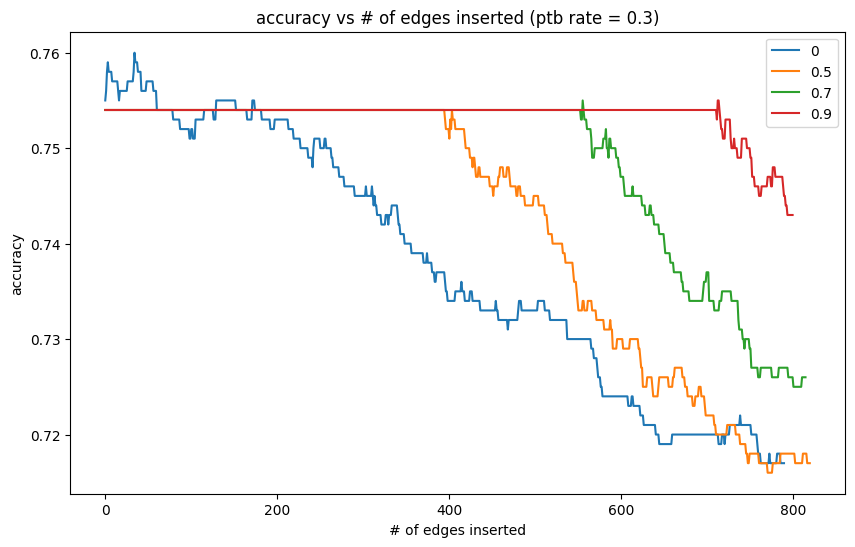

In [56]:
import matplotlib.pyplot as plt

# split_dic2 = copy.copy(split_dic)

# for label, values in split_dic2.items():
#     for i in range(len(values)):
#         split_dic2[label][i] = - abs(values[i] - initial_loss)

plt.figure(figsize=(10, 6))

# Iterate over the dictionary and plot each list
for label, values in split_dic.items():
    plt.plot(values, label=str(label))

plt.xlabel('# of edges inserted')
plt.ylabel('accuracy')
plt.title('accuracy vs # of edges inserted (ptb rate = 0.3)')
plt.legend()

plt.show()